Here's some guide for this assessment:

1. Obtain the dataset file from the assessment instruction.
2. The dataset file is split into image and label folder. You need to find a way to read all the images and labels as numpy array.
3. The most straight forward way to read an image is to use OpenCV (cv2.imread())
4. Resize your image and label into width and height of (128,128)
5. For the label, it is in the form of binary mask image (black and white image), you need to find a way to read the mask image, then process the value of the pixels so that they become class label ([0,255] --> [0,1])
6. You can perform train test split on the numpy arrays for the images and labels using scikit learn.
7. You can convert the numpy array into tensorflow tensors using this method: tf.data.Dataset.from_tensor_slices()
8. You can combine the images and labels together to form a single dataset using this method: tf.data.Dataset.zip(), do this for both train and test data.
9. Perform the same dataset preparation step as the demo.
10. Construct a UNet, then train this model so that it reaches at least 80% accuracy for both train and test.
11. Deploy the model and make prediction

(Hint: You can refer to the image segmentation tutorial from tensorflow)

In [2]:
#1. Import packages
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras import layers,losses,metrics,activations,optimizers,initializers,regularizers,callbacks,applications
from keras.utils import plot_model
from tensorflow.keras.models import load_model
import keras
from IPython.display import clear_output
import datetime
import matplotlib.pyplot as plt
import cv2
import sys
import numpy as np
import glob, os

filepath = r"C:\Users\User\OneDrive\Desktop\YP\Subjects\Capstone\project4\train"
images = []
masks = []

In [3]:
#Use os.listdir() method to list down all the image file, then use a for loop to read the images.
"""
for ____ in os.listdir(____):
    function you will use here:
    os.path.join()
    cv2.imread()
    cv2.cvtColor()
    cv2.resize()

Use this for loop, do the same thing for the label. But I suggest you read the label as a grayscale image.
"""

#2. Load images
image_path = os.path.join(filepath,'inputs')
for img in os.listdir(image_path):
    #Get the full path of the image file
    full_path = os.path.join(image_path,img)
    #Read the image file based on the full path
    img_np = cv2.imread(full_path)
    #Convert the image from bgr to rgb
    img_np = cv2.cvtColor(img_np,cv2.COLOR_BGR2RGB)
    #Resize the image into 128x128
    img_np = cv2.resize(img_np,(128,128))
    #Place the image into the empty list
    images.append(img_np)

#3. Load masks
mask_path = os.path.join(filepath,'masks')
for mask in os.listdir(mask_path):
    #Get the full path of the mask file
    full_path = os.path.join(mask_path,mask)
    #Read the mask file as a grayscale image
    mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
    #Resize the image into 128x128
    mask_np = cv2.resize(mask_np,(128,128))
    #Place the mask into the empty list
    masks.append(mask_np)

In [ ]:
#4. Convert the list of np array into a full np array
images_np = np.array(images)
masks_np = np.array(masks)

In [5]:
#5. Data preprocessing
#5.1. Expand the mask dimension to include the channel axis
masks_np_exp = np.expand_dims(masks_np,axis=-1)
#5.2. Convert the mask value into just 0 and 1
converted_masks_np = np.round(masks_np_exp/255)
#5.3. Normalize the images pixel value
normalized_images_np = images_np/255.0

In [6]:
#6. Perform train test split
from sklearn.model_selection import train_test_split
SEED = 12345
X_train,X_test,y_train,y_test = train_test_split(normalized_images_np,converted_masks_np,shuffle=True,random_state=SEED)

In [7]:
#7. Convert the numpy array into tensorflow tensors
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

In [8]:
#8. Combine features and labels together to form a zip dataset
train = tf.data.Dataset.zip((X_train_tensor,y_train_tensor))
test = tf.data.Dataset.zip((X_test_tensor,y_test_tensor))

In [9]:
"""
Continue the rest of your assessment here.
"""
#Convert the zip dataset into prefetch dataset

'\nContinue the rest of your assessment here.\n'

In [10]:
# Prefetch datsets (Set batch size)
BATCH_SIZE = 32

# Convert train and test datasets into batches
train_dataset = train.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

# Apply prefetching to overlap data preprocessing and model training
AUTOTUNE = tf.data.AUTOTUNE  # Automatically tunes the prefetch buffer size
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [11]:
# # Expand mask dimensions and normalize
# masks_np_exp = np.expand_dims(masks_np, axis=-1)
# normalized_masks = np.round(masks_np_exp / 255)
# normalized_images = images_np / 255.0

# # Train-test split
# SEED = 42
# X_train, X_test, y_train, y_test = train_test_split(
#     normalized_images, normalized_masks, test_size=0.2, random_state=SEED
# )

# # Convert to tf.data.Dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# # Prefetch datasets
# BATCH_SIZE = 32
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = (
#     train_dataset
#     .batch(BATCH_SIZE)
#     .prefetch(buffer_size=AUTOTUNE)
# )
# test_dataset = (
#     test_dataset
#     .batch(BATCH_SIZE)
#     .prefetch(buffer_size=AUTOTUNE)
# )


In [12]:
def unet_model(output_channels):
    inputs = layers.Input(shape=(128, 128, 3))

    # Downsampling
    conv1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(conv4)

    # Upsampling
    up6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(conv4)
    up6 = layers.concatenate([up6, conv3])
    conv6 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(up6)
    conv6 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(conv6)

    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv6)
    up7 = layers.concatenate([up7, conv2])
    conv7 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(up7)
    conv7 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(conv7)

    up8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv7)
    up8 = layers.concatenate([up8, conv1])
    conv8 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(up8)
    conv8 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv8)

    outputs = layers.Conv2D(output_channels, (1, 1), activation="sigmoid")(conv8)

    return Model(inputs, outputs)


In [13]:
OUTPUT_CHANNELS = 1  # Binary segmentation (background vs object)

model = unet_model(OUTPUT_CHANNELS)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    131,200 │ conv2d_9[0][0]  

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

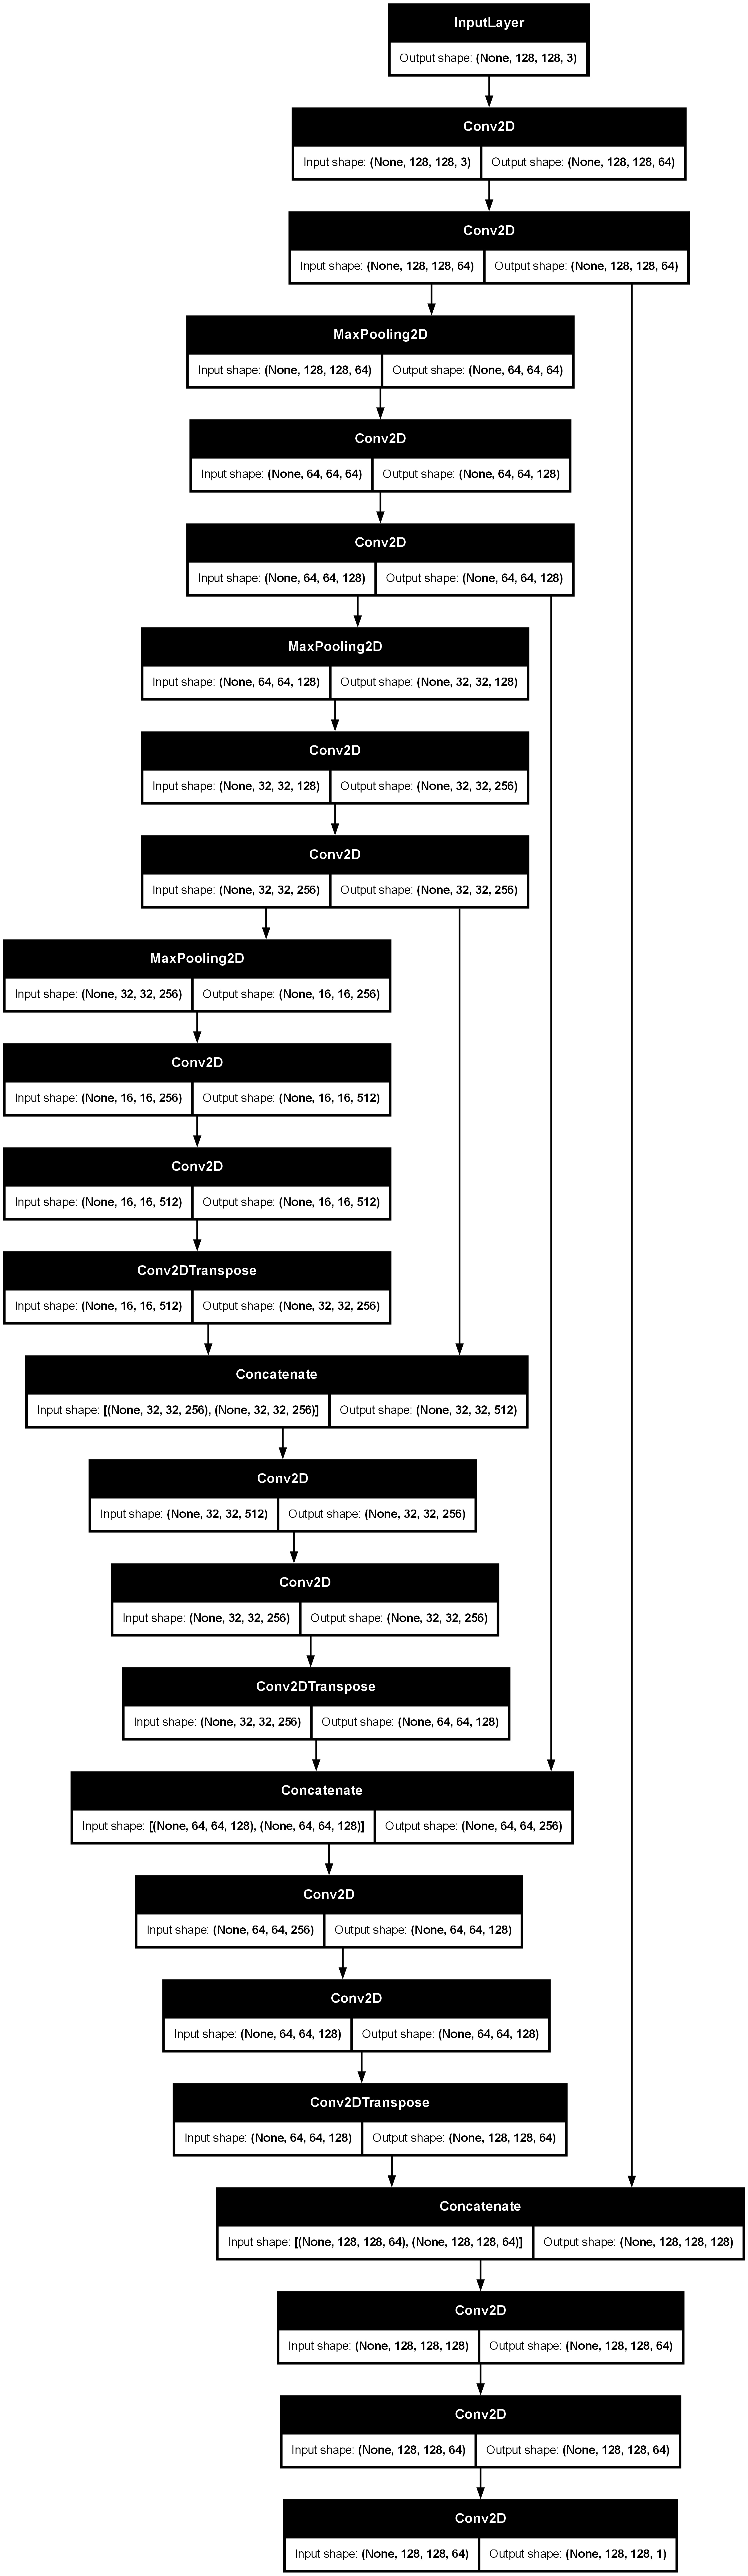

In [14]:
keras.utils.plot_model(model, to_file="static/mobilenet_v2.png",show_shapes=True)

In [25]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = callbacks.EarlyStopping(patience=5,monitor='val_accuracy',min_delta=0.01,restore_best_weights=True)

In [26]:
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback,early_stopping]
)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 446s 30s/step - accuracy: 0.8585 - loss: 0.5955 - val_accuracy: 0.8587 - val_loss: 0.5635
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 508s 34s/step - accuracy: 0.8585 - loss: 0.5470 - val_accuracy: 0.8587 - val_loss: 0.4449
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 495s 33s/step - accuracy: 0.8585 - loss: 0.4126 - val_accuracy: 0.8587 - val_loss: 0.3763
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 481s 32s/step - accuracy: 0.8585 - loss: 0.3475 - val_accuracy: 0.8587 - val_loss: 0.3247
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 480s 32s/step - accuracy: 0.8585 - loss: 0.2944 - val_accuracy: 0.8587 - val_loss: 0.2723
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 475s 32s/step - accuracy: 0.8585 - loss: 0.2609 - val_accuracy: 0.8587 - val_loss: 0.2384


In [27]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.8596 - loss: 0.5693
Test Accuracy: 85.87%


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


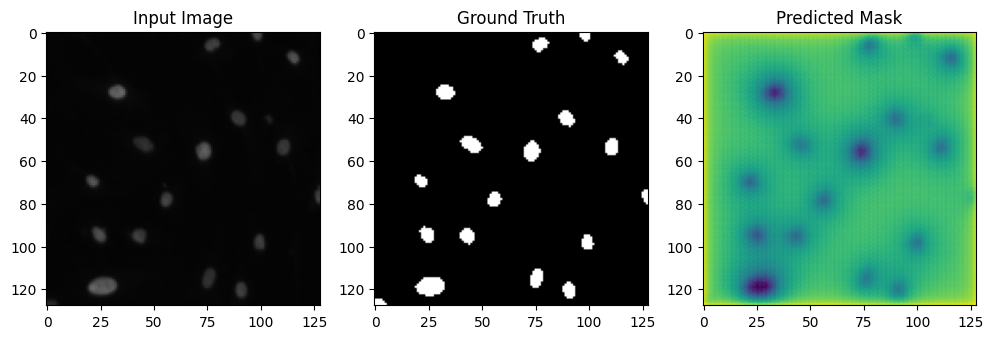

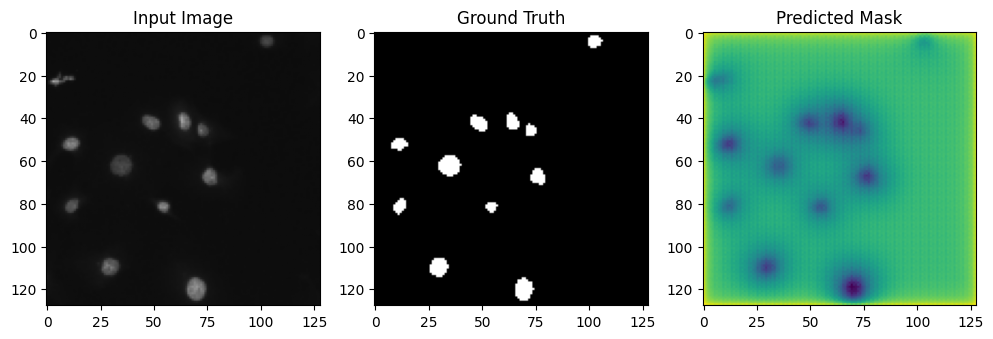

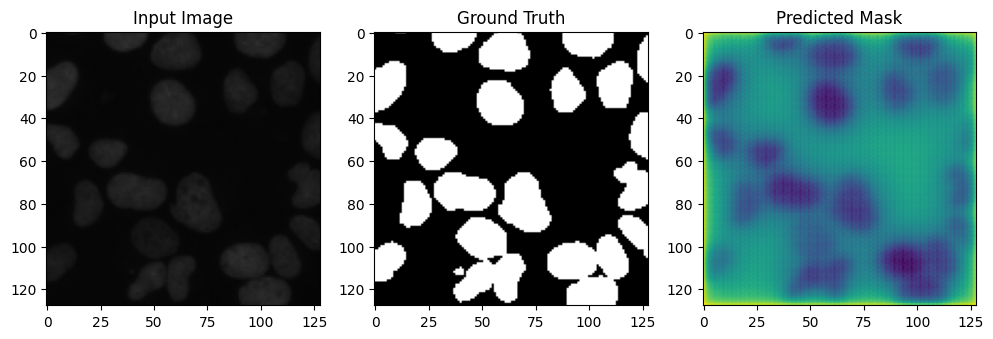

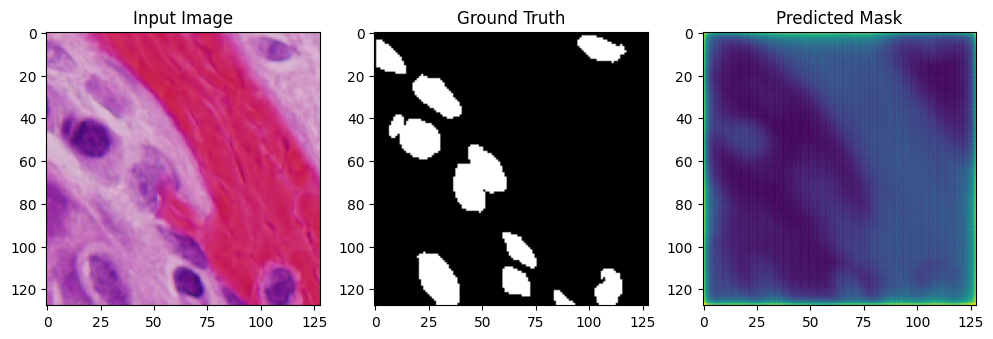

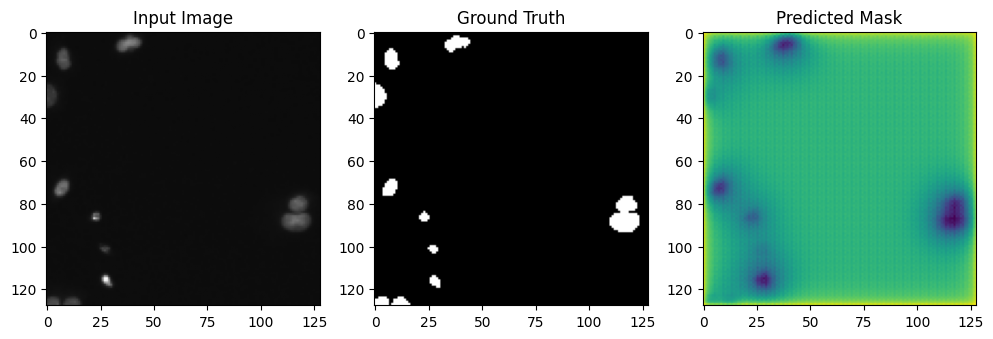

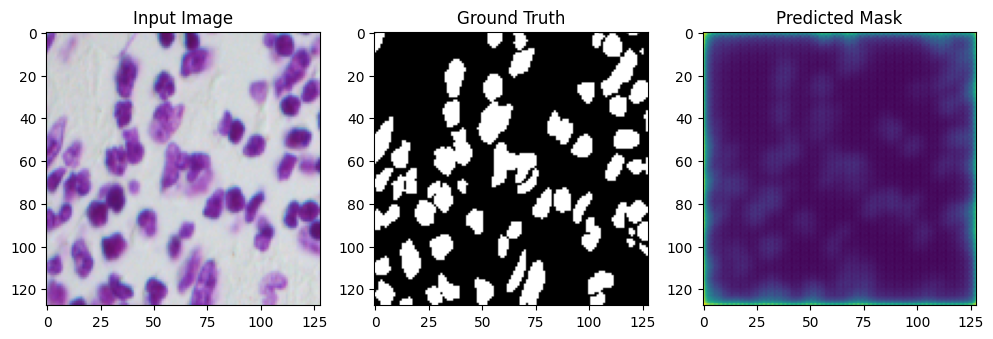

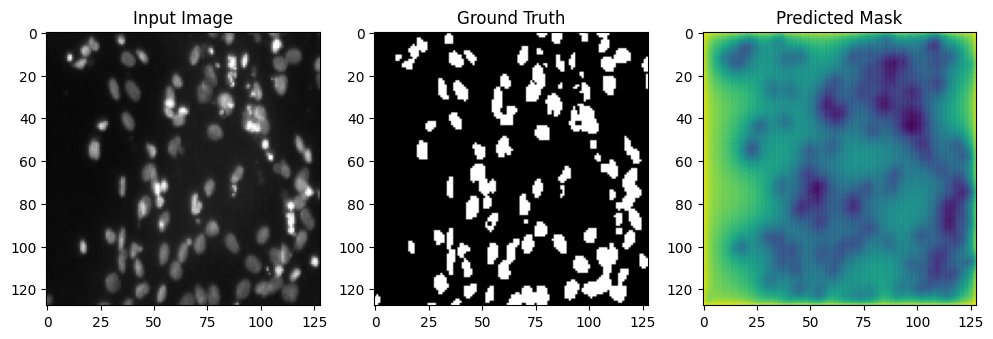

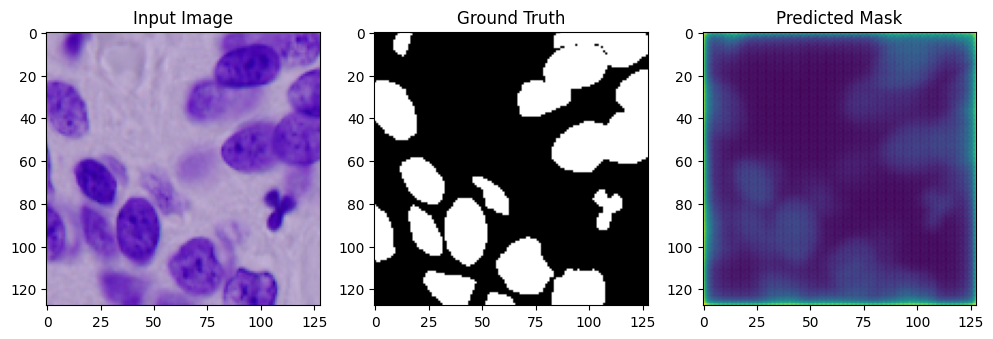

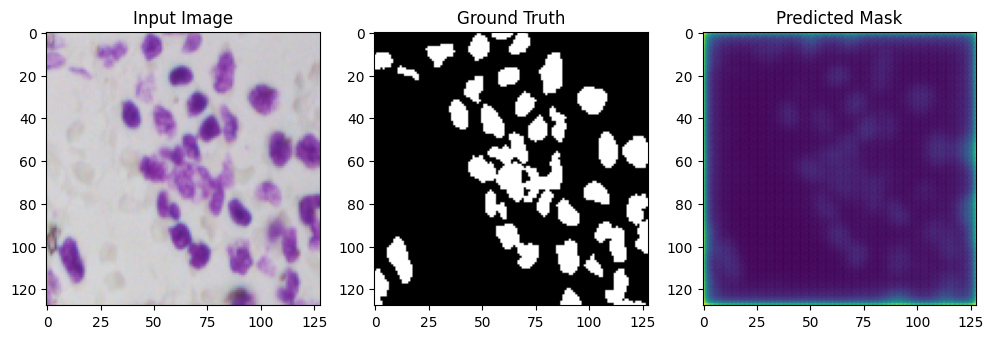

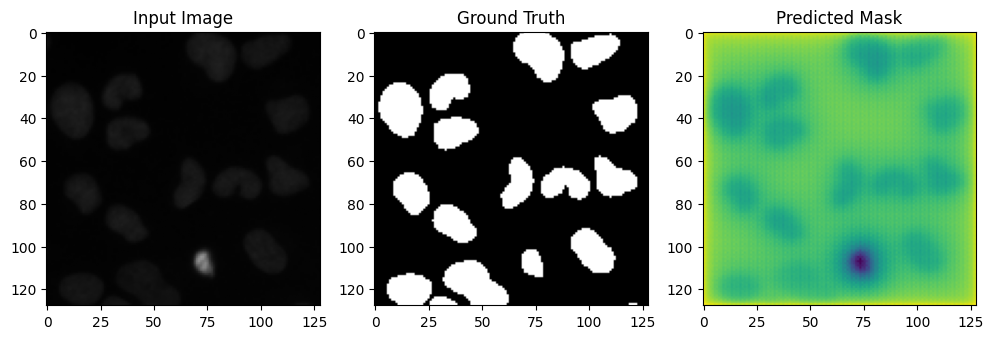

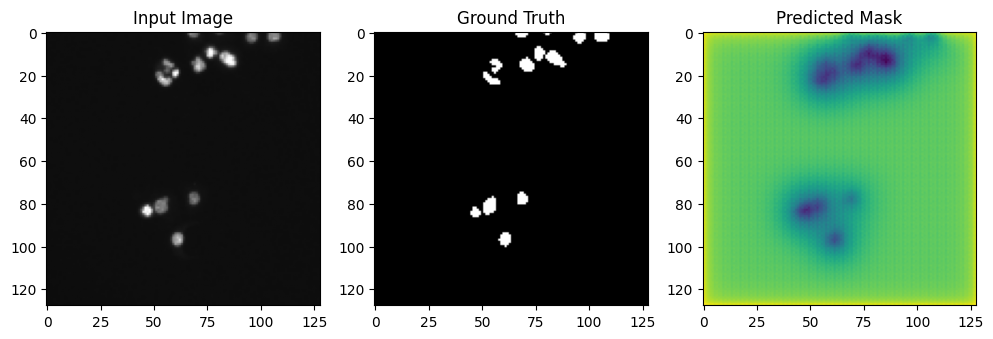

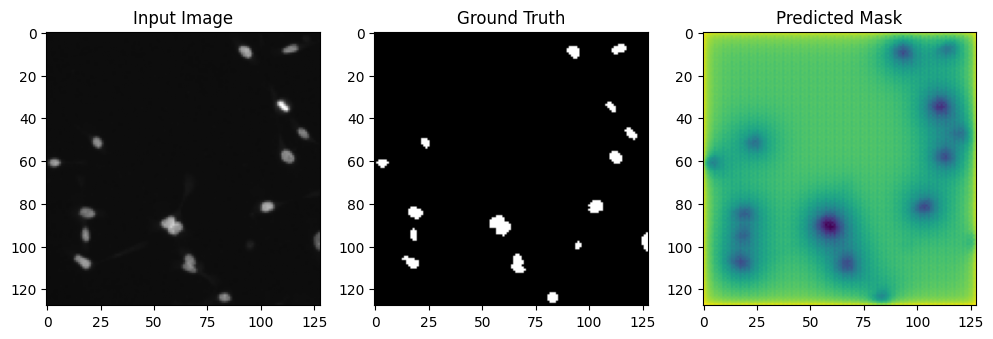

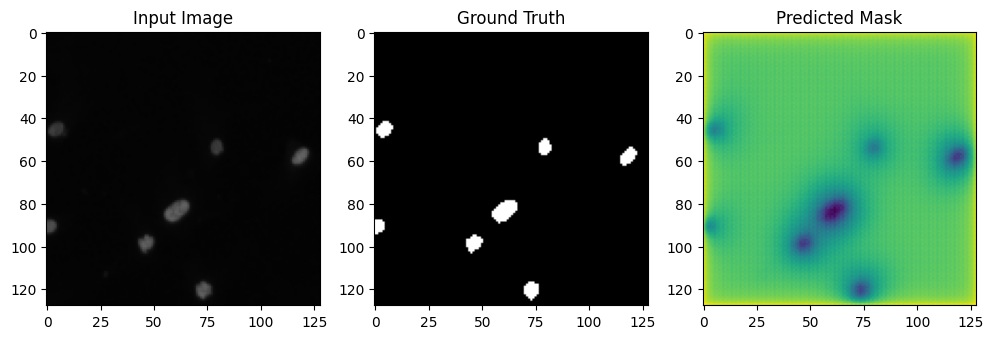

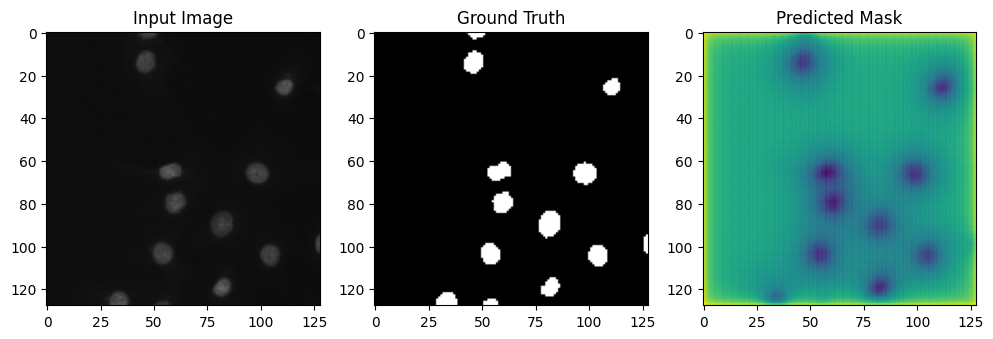

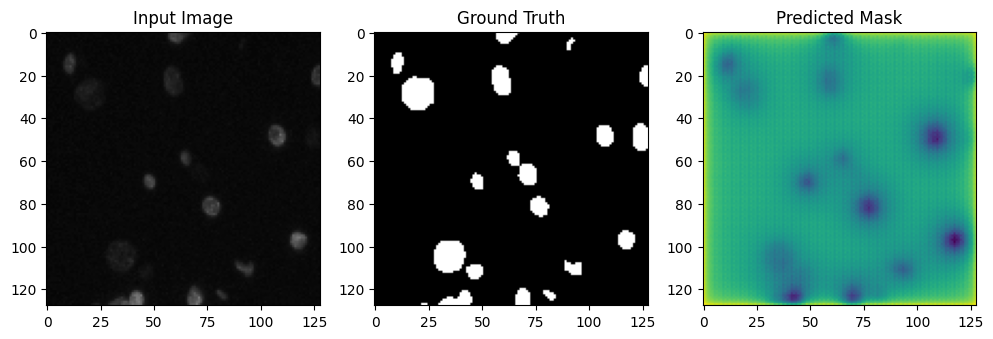

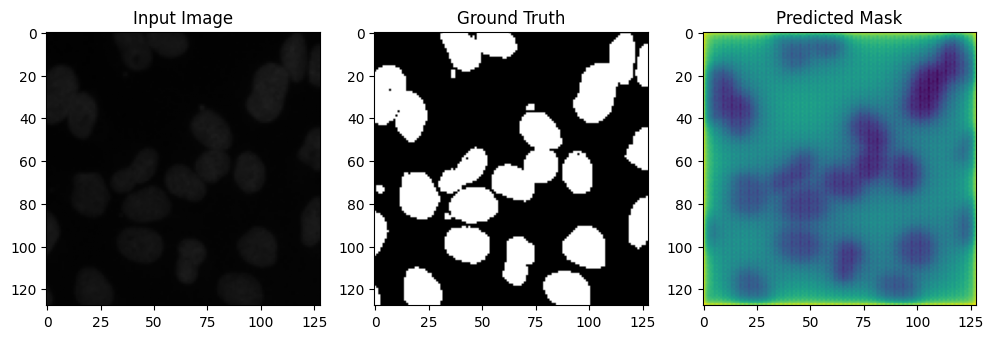

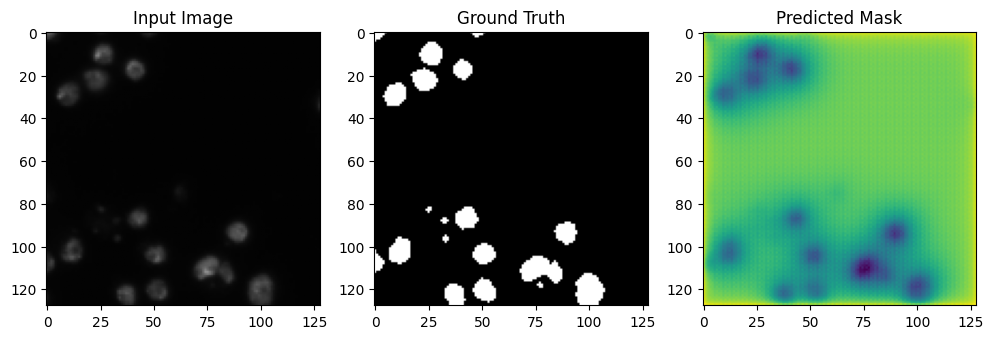

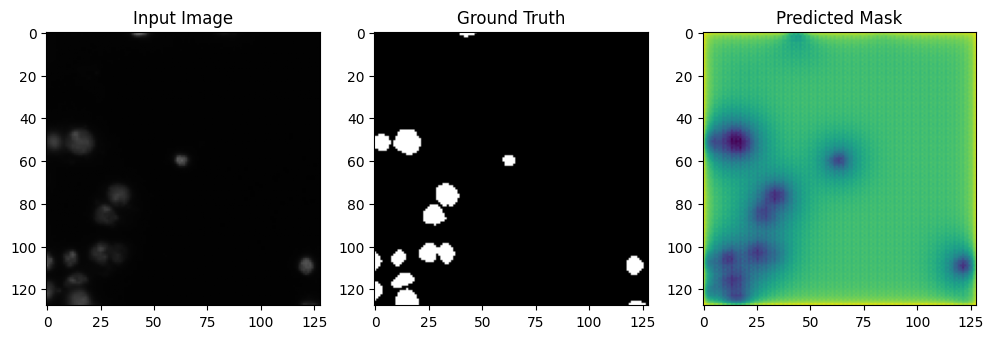

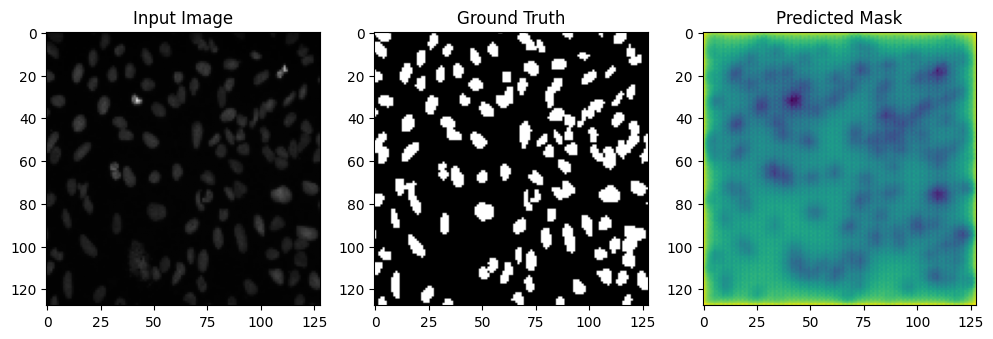

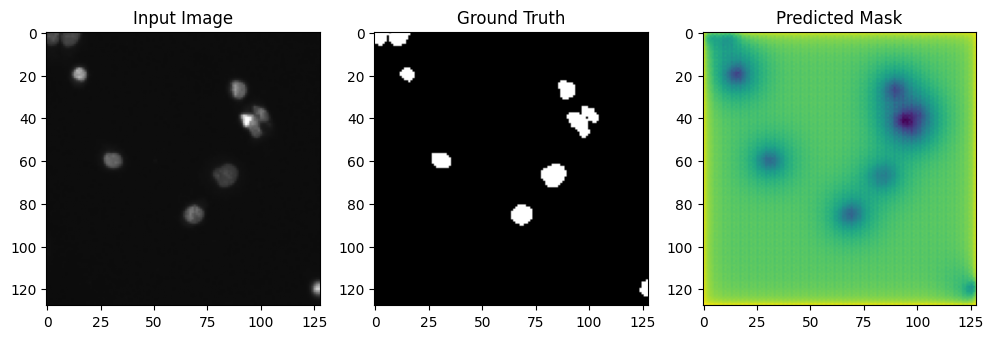

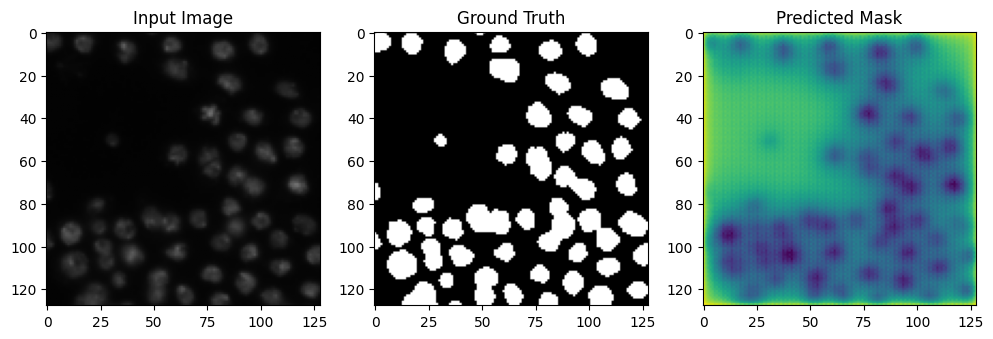

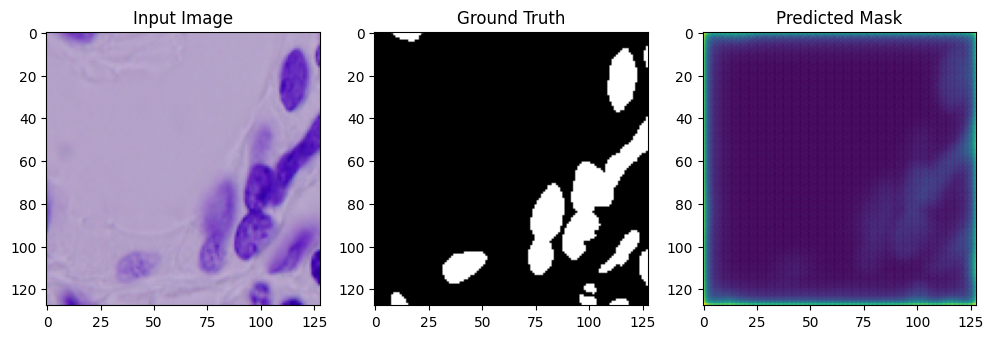

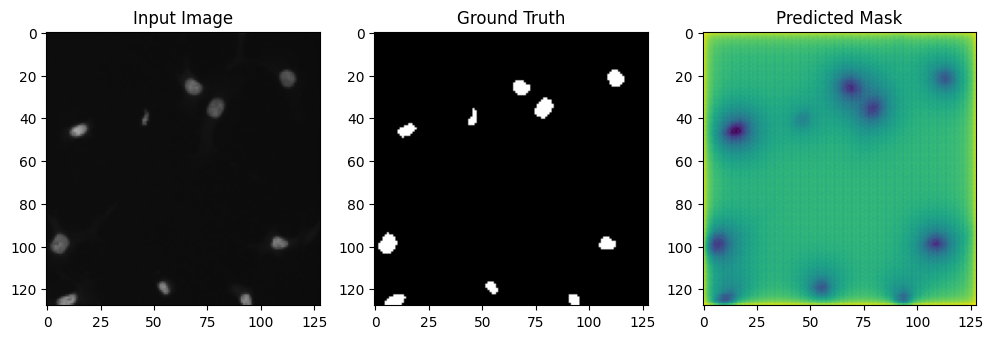

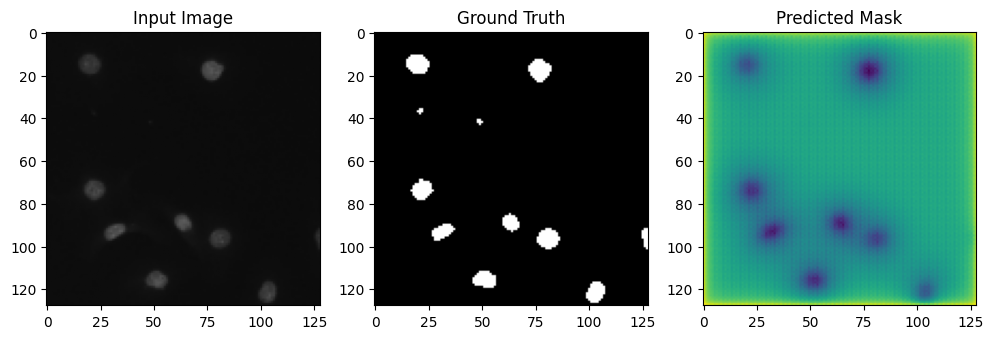

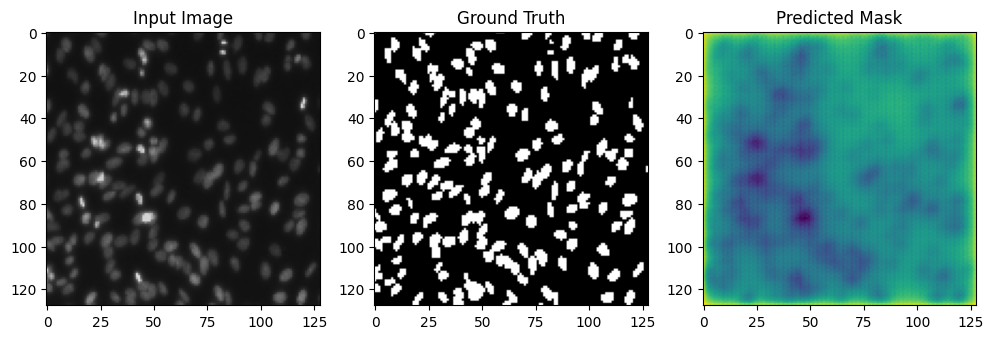

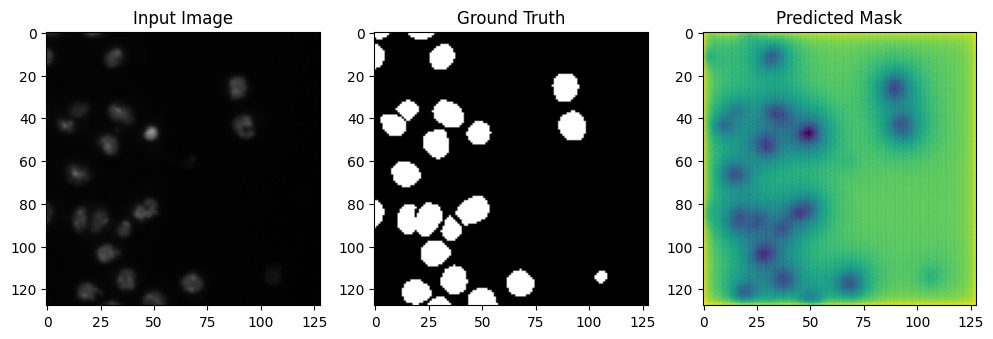

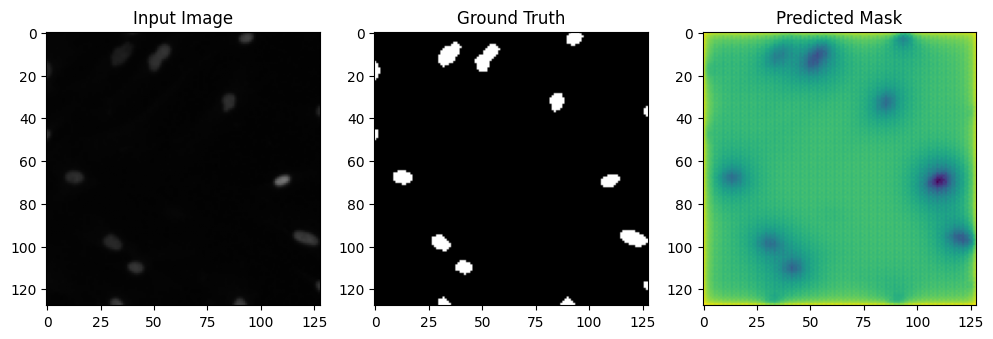

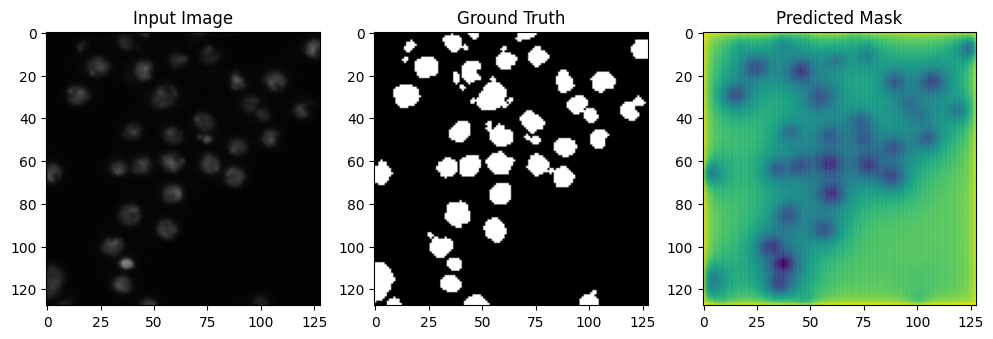

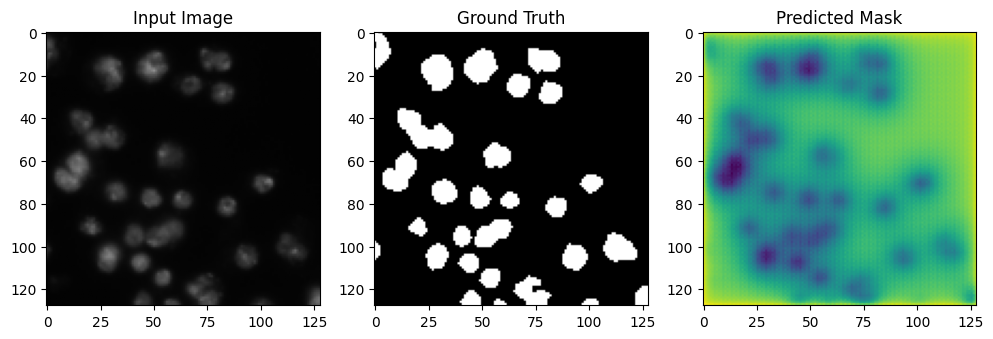

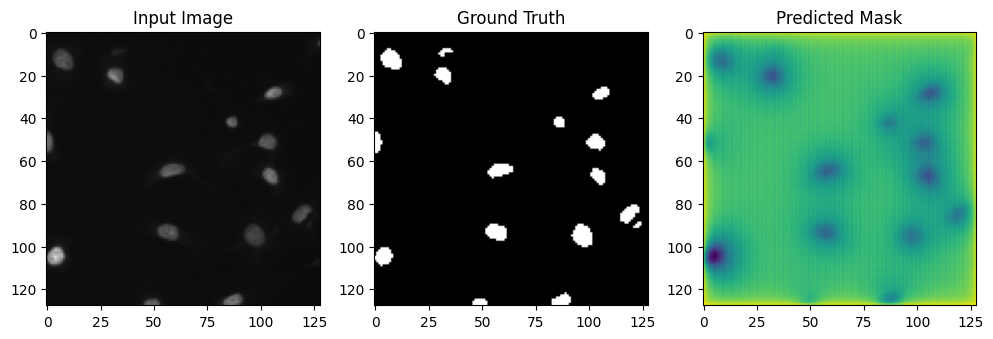

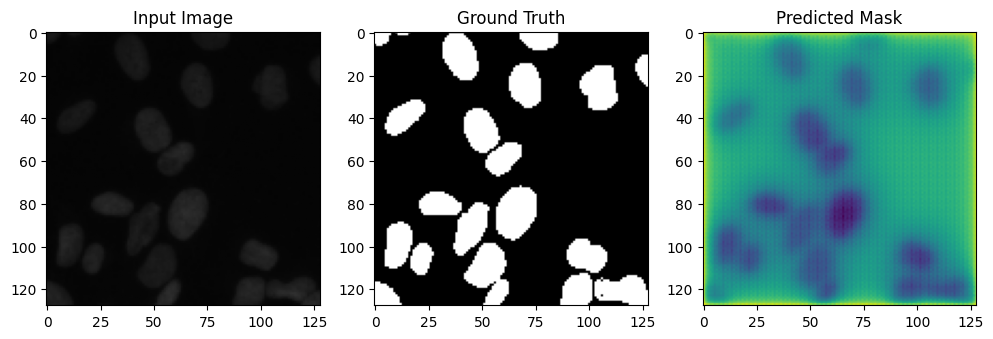

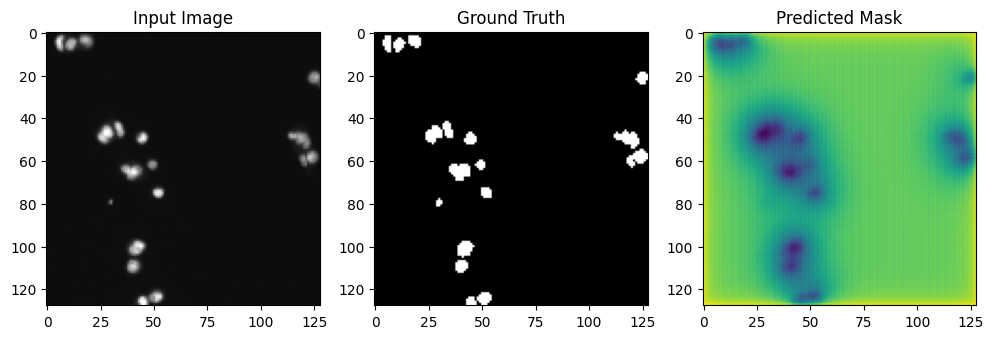

In [28]:
def display_sample_predictions(dataset, num_samples=3):
    for images, masks in dataset.take(num_samples):
        predictions = model.predict(images)
        for i in range(len(images)):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(images[i])
            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(masks[i, :, :, 0], cmap="gray")
            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(predictions[i, :, :, 0], cmap="viridis")
            plt.show()

# Display predictions
display_sample_predictions(test_dataset, num_samples=1)


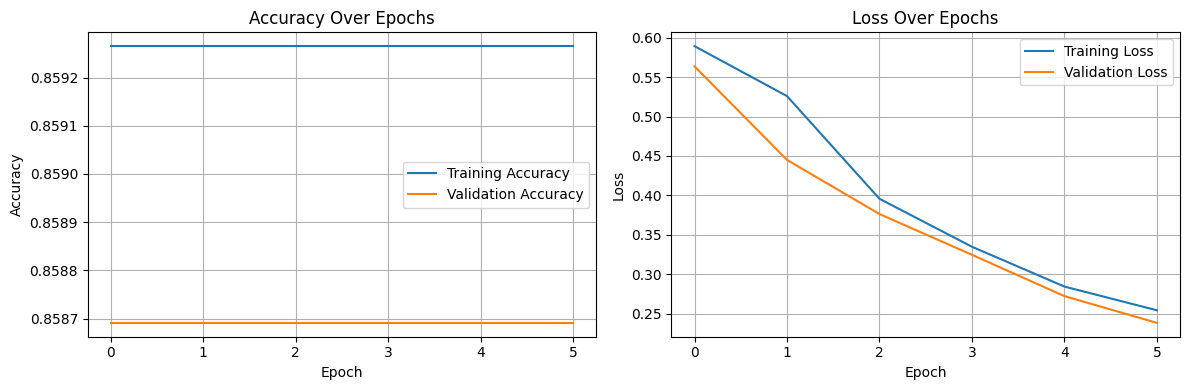

In [29]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [30]:
print(f"Run tensorboard --logdir={log_dir} to view logs in TensorBoard.")

Run tensorboard --logdir=logs/20250115-122801 to view logs in TensorBoard.


In [31]:
# saving model in a .h5 format file
os.makedirs("models",exist_ok=True)
model.save("models/unet.h5")


In [32]:
# saving model architecture
# loaded_model = load_model('models/mobilenet_v2.h5')
# loaded_model.summary()

In [33]:
# performance and reports
test_loss, test_accuracy = model.evaluate(train_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

val_loss, val_accuracy = model.evaluate(test_dataset)
print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 109s 7s/step - accuracy: 0.8585 - loss: 0.5680
Test Loss: 0.5661201477050781
Test Accuracy: 0.8592652082443237
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.8596 - loss: 0.5693
Val Loss: 0.5634888410568237
Val Accuracy: 0.8586910963058472
